### Exploratory Data Analysis

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import cv2
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# '/content/gdrive/My Drive/adversarial-xray'
sys.path.append(ROOT_DIR)  
import helpers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
def crop_and_resize(img, resize_dim=256):
    img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img

def pad(im, desired_size = 256):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im


def get_data(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=crop_and_resize(img)
    return img

In [5]:
# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')
OUTPUTS = os.path.join(ROOT_DIR, 'outputs')
DATASET, OUTPUTS

('/content/gdrive/My Drive/adversarial-xray/dataset',
 '/content/gdrive/My Drive/adversarial-xray/outputs/auc')

In [6]:
os.listdir(DATASET + "/data")

['Training_GroundTruth_forGAN.csv',
 'Test_GroundTruth.csv',
 'Training_GroundTruth.csv',
 '.ipynb_checkpoints',
 'Training_Data',
 'Test_Data',
 'Training_Data_forGAN']

In [7]:
# IMAGES PATH
IMAGES = os.path.join(DATASET, 'data', 'Training_Data')
# GROUND TRUTH PATH
GT = os.path.join(DATASET, 'data', 'Training_GroundTruth.csv')
len(os.listdir(IMAGES)), len(os.listdir(IMAGES))

(2562, 2562)

In [8]:
# Read the metadata
df = pd.read_csv(GT, sep=',', names=["FILENAME", "CLASS"])
df.head()

,FILENAME,CLASS
0,COVID_train194,COVID-19
1,COVID_train247,COVID-19
2,COVID_train213,COVID-19
3,COVID_train350,COVID-19
4,COVID_train068,COVID-19


In [9]:
# filenames and gts
filenames = df['FILENAME'].values
gt = df['CLASS'].values
len(gt)

2552

In [10]:
filenames[:6]

array(['COVID_train194', 'COVID_train247', 'COVID_train213',
       'COVID_train350', 'COVID_train068', 'COVID_train267'], dtype=object)

In [62]:
df.loc[df['CLASS'] == 'COVID-19']
df.loc[df['CLASS'] == 'NORMAL']


,FILENAME,CLASS
1533,NORMAL_train168,NORMAL
1534,NORMAL_train632,NORMAL
1535,NORMAL_train014,NORMAL
1536,NORMAL_train295,NORMAL
1537,NORMAL_train521,NORMAL
...,...,...
2547,NORMAL_train925,NORMAL
2548,NORMAL_train440,NORMAL
2549,NORMAL_train483,NORMAL
2550,NORMAL_train268,NORMAL


In [0]:
def bar_chart(figsize, df):
    fig, ax= plt.subplots(figsize = figsize)

    ax = sns.countplot(y='CLASS', data=df)
    plt.title("Class Distribution in Data Set")
    ax.set(xlabel='Number of Samples')
    ax.set(ylabel='')

    ax.set_yticks(range(len(np.unique(df['CLASS'].values))))
    # ax.set_yticklabels(unique_value_list, minor=False)

    total = len(df['CLASS'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    plt.savefig("{}/outputs/numberofclcasses.jpeg".format(ROOT_DIR), dpi=1000)
    plt.show()

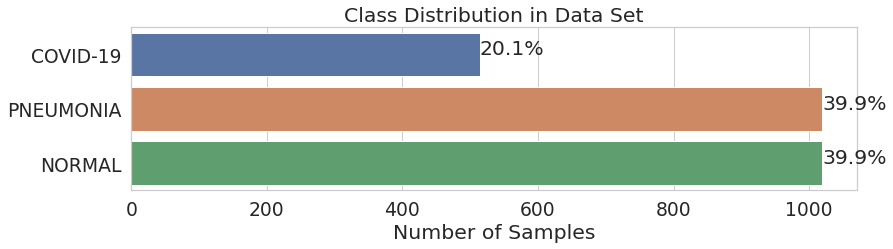

In [46]:
bar_chart((13,3), df)

In [36]:
labels = []
for s in gt:
    if s == "NORMAL" or s == 0.0 :
        labels.append(0)
    if s == "COVID-19" or s == 1.0:
        labels.append(1)
    if s == "PNEUMONIA" or s == 2.0:
        labels.append(2)
        
len(labels)
labels[:10]

2552

In [38]:
gt_t = []

for g in labels:
    if g == 0:
        gt_t.append("NORMAL")
    elif g==1:
        gt_t.append("COVID-19")
    else:
        gt_t.append("PNEUMONIA")
gt_t = np.array(gt_t)

gt_t.shape

(2552,)

In [47]:
inp_feat = []
g_t = []


c = []
n = []
p = []

for f, l in tqdm(zip(filenames[:], labels[:])):
    f = "{}/{}.jpg".format(IMAGES, f)
    img = get_data(f)
    inp_feat.append(img)
    g_t.append(l)
    if l == 1:
        c.append(img)
    if l == 0:
        n.append(img)
    if l == 2:
        p.append(img)
    else:
        pass
    img = None

# make nummpy arrays
#inp_feat = np.array(inp_feat)
#g_t = np.array(g_t)

c = np.array(c)
n = np.array(n)
p = np.array(p)

#print(inp_feat.shape, g_t.shape)
print(c.shape, n.shape, p.shape)

2552it [11:37,  3.66it/s]


(514, 256, 256, 3) (1019, 256, 256, 3) (1019, 256, 256, 3)


In [0]:
#inp_feat.shape, g_t.shape

In [48]:
x = c[-20:]

a, b = 4, 5
x = np.reshape(x, (a, b, 256, 256, 3))

y = n[-20:]
y = np.reshape(y, (a, b, 256, 256, 3))

z = p[-20:]
z = np.reshape(y, (a, b, 256, 256, 3))

x.shape, y.shape, z.shape

((4, 5, 256, 256, 3), (4, 5, 256, 256, 3), (4, 5, 256, 256, 3))

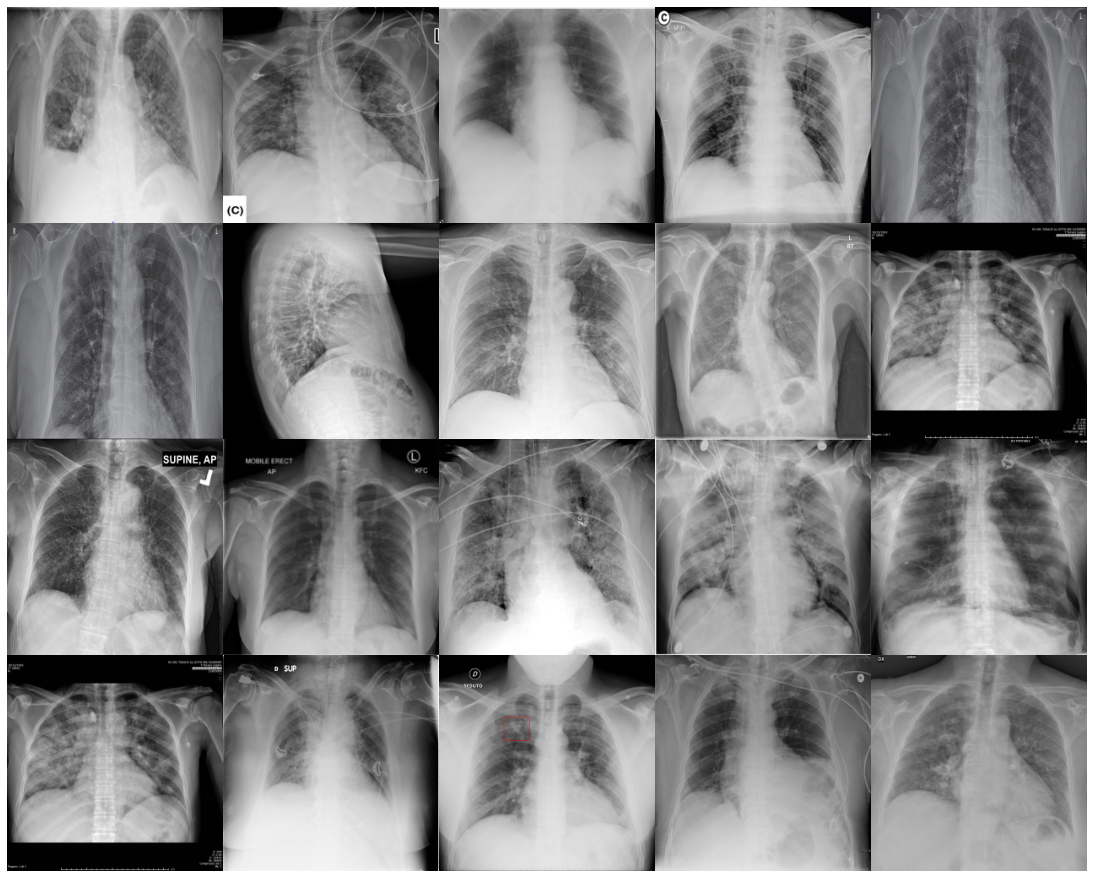

In [51]:
from numpy.random import rand
import matplotlib.pyplot as plt

test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.jpeg'.format("{}/outputs/".format(ROOT_DIR), "COVID-19"), dpi=1000)
plt.show()

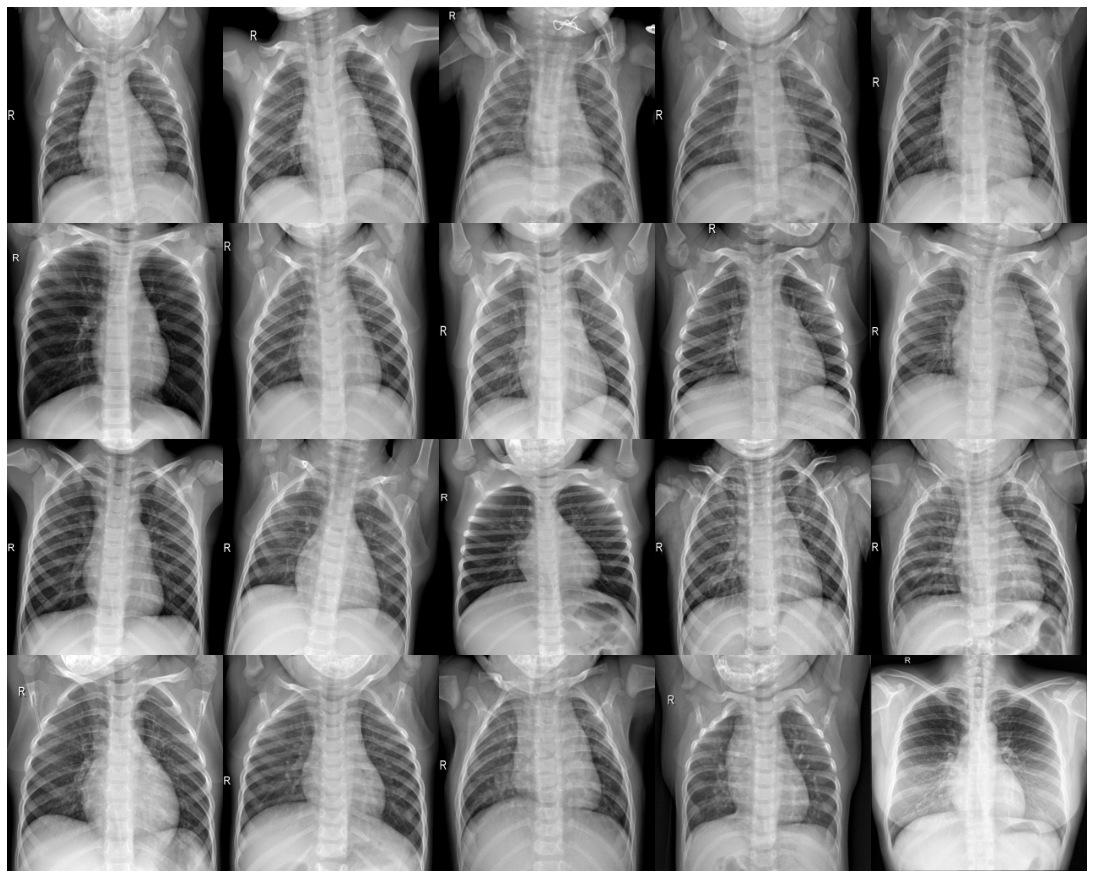

In [52]:
from numpy.random import rand
import matplotlib.pyplot as plt

test_data = y
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.pdf'.format("{}/outputs/".format(ROOT_DIR), "normal"), dpi=1000)
plt.show()

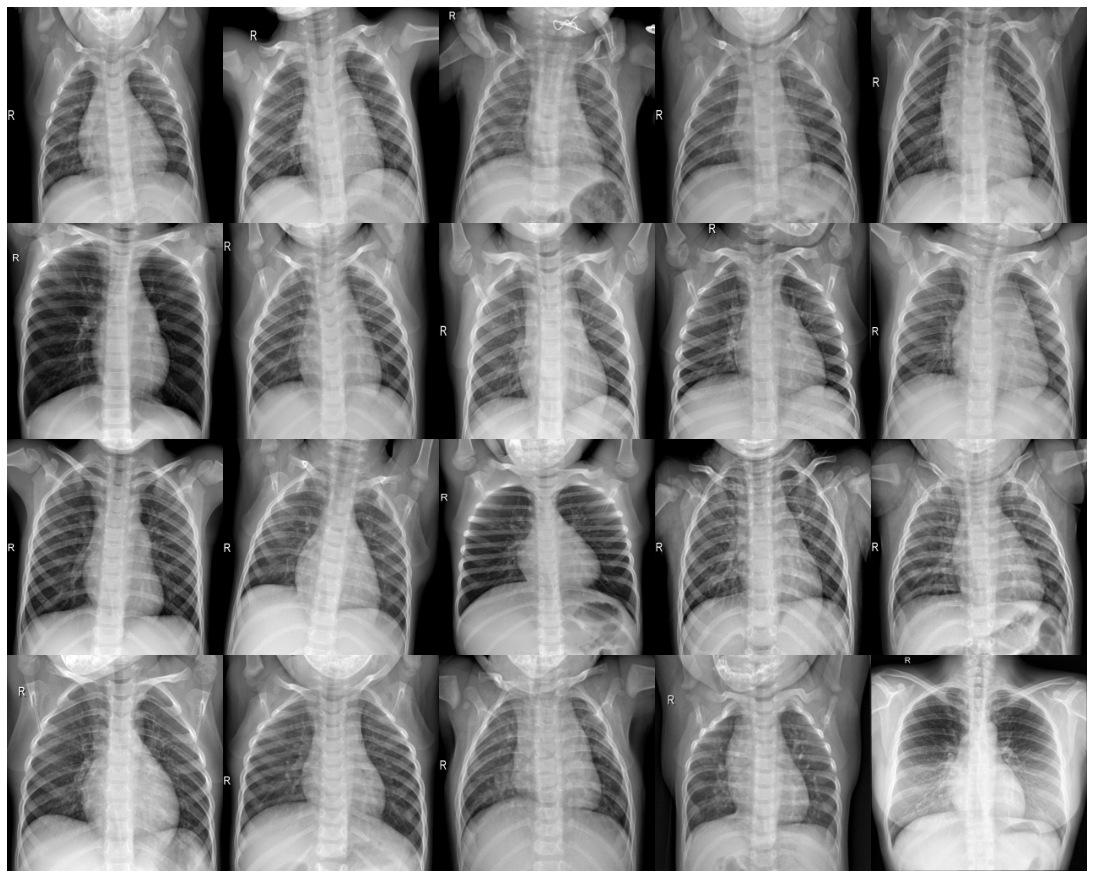

In [53]:
from numpy.random import rand
import matplotlib.pyplot as plt

test_data = z
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.pdf'.format("{}/outputs/".format(ROOT_DIR), "pneumonia"), dpi=1000)
plt.show()

## PCA

In [2]:
dataset_path = os.path.join(ROOT_DIR, "dataset", "dataNumpy")

x_train_ = np.load("{}/x_train.npy".format(dataset_path))
y_train_ = np.load("{}/y_train.npy".format(dataset_path))
x_up_ = np.load("{}/x_upsampled.npy".format(dataset_path))
y_up_ = np.load("{}/y_upsampled.npy".format(dataset_path))

In [3]:
x_train_ = x_train_.astype('float32')
x_train_ /= 255

In [4]:
y_train = []
for i in range(len(y_train_)):
    y_train.append(np.argmax(y_train_[i]))
y = np.array(y_train)
# print(y_train)
X = x_train_.reshape(2321, 256*256*3)
print(X.shape, y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))


In [5]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [6]:
y_up = []
for i in range(len(y_up_)):
    y_up.append(np.argmax(y_up_[i]))
y1 = np.array(y_up)
# print(y_train)
X1 = x_up_.reshape(3219, 256*256*3)
print(X1.shape, y1.shape)

feat_cols1 = [ 'pixel'+str(i) for i in range(X1.shape[1]) ]
df1 = pd.DataFrame(X1,columns=feat_cols1)
df1['y'] = y1
df1['label'] = df1['y'].apply(lambda i: str(i))
X1, y1 = None, None
print('Size of the dataframe: {}'.format(df1.shape))


In [7]:
# For reproducability of the results
np.random.seed(42)
rndperm1 = np.random.permutation(df1.shape[0])

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [9]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [10]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

labelTups = [('NORMAL', 0), ('COVID-19', 1), ('PNEUMONIA', 2)]

cmap = cm.get_cmap("tab10")
colors = [cmap(np.float(i/2)) for i in [0, 1, 2]]
custom_lines = [Line2D([0], [0], linestyle="none", marker='.', markeredgecolor='k', markerfacecolor=c, markeredgewidth=.1, markersize=20) for c in colors]
ax.legend(custom_lines, [lt[0] for lt in labelTups], loc='best', bbox_to_anchor=(.7, .5))


plt.show()

In [11]:
pca1 = PCA(n_components=3)
pca_result1 = pca1.fit_transform(df1[feat_cols1].values)
df1['pca-one'] = pca_result1[:,0]
df1['pca-two'] = pca_result1[:,1] 
df1['pca-three'] = pca_result1[:,2]
print('Explained variation per principal component: {}'.format(pca1.explained_variance_ratio_))

In [12]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df1.loc[rndperm1,:],
    legend="full",
    alpha=0.3
)

In [13]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df1.loc[rndperm1,:]["pca-one"], 
    ys=df1.loc[rndperm1,:]["pca-two"], 
    zs=df1.loc[rndperm1,:]["pca-three"], 
    c=df1.loc[rndperm1,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

labelTups = [('NORMAL', 0), ('COVID-19', 1), ('PNEUMONIA', 2)]

cmap = cm.get_cmap("tab10")
colors = [cmap(np.float(i/2)) for i in [0, 1, 2]]
custom_lines = [Line2D([0], [0], linestyle="none", marker='.', markeredgecolor='k', markerfacecolor=c, markeredgewidth=.1, markersize=20) for c in colors]
ax.legend(custom_lines, [lt[0] for lt in labelTups], loc='best', bbox_to_anchor=(.7, .5))

plt.show()